In [2]:
import glob
import os
import pickle
import gc
import numpy as np
from skimage import filters
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from GoogletNet import GoogLeNet
from SISE import SISE
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.stats import pearsonr

In [3]:
tf.config.set_visible_devices([], 'GPU')

In [4]:
def otsu_binary(img):
    thr = filters.threshold_otsu(img)
    binary = img > thr
    return np.multiply(binary, 255)

# 이미지 불러오기 및 전처리
def load_and_preprocess_images(img_paths, target_size=(224,224)):
    img_array_list = []
    for img_path in img_paths:
        img = np.array(Image.open(tf.io.gfile.GFile(img_path,'rb')).convert('RGB').resize(target_size, Image.BILINEAR), dtype=np.float32)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        img_array_list.append(img)
    return np.vstack(img_array_list)

def create_cav_training_set(concepts, bottleneck, acts):
    x = []
    labels = []
    labels2text = {}
    min_data_points = np.min([acts[concept][bottleneck].shape[0] for concept in acts.keys()])

    for I, concept in enumerate(concepts):
        x.extend(acts[concept][bottleneck][:min_data_points].reshape(min_data_points, -1))
        labels.extend([I] * min_data_points)
        labels2text[I] = concept
    
    x = np.array(x)
    labels = np.array(labels)

    return x, labels, labels2text

def train_lm(lm, x, y, labels2text):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, stratify=y)
    
    lm.fit(x_train, y_train)
    y_pred = lm.predict(x_test)
    
    num_classes = max(y) + 1
    acc = {}
    num_correct = 0
    for class_id in range(num_classes):
        # get indices of all test data that has this class.
        idx = (y_test == class_id)
        acc[labels2text[class_id]] = metrics.accuracy_score(
          y_pred[idx], y_test[idx])
        # overall correctness is weighted by the number of examples in this class.
        num_correct += (sum(idx) * acc[labels2text[class_id]])
    acc['overall'] = float(num_correct) / float(len(y_test))
    tf.compat.v1.logging.info('acc per class %s' % (str(acc)))
    return acc

def kernel(point, xmat, tau):
    m, n = np.shape(xmat)
    weights = np.mat(np.eye((m)))
    for j in range(m):
        diff = point - xmat[j]
        weights[j, j] = np.exp(np.dot(diff, diff.T) / (-2.0 * tau ** 2))
    return weights


def local_weighted_regression(X, y, tau, batch_size=100):
    m, n = X.shape
    predictions = np.zeros(m)
    
    for start in range(0, m, batch_size):
        end = min(start + batch_size, m)
        X_batch = X[start:end]
        y_batch = y[start:end]

        for i in range(X_batch.shape[0]):
            point = X_batch[i]
            weights = kernel(point, X, tau)
            W_X = weights @ X
            try:
                theta = np.linalg.inv(W_X.T @ W_X) @ W_X.T @ weights @ y
            except np.linalg.LinAlgError:
                theta = np.linalg.pinv(W_X.T @ W_X) @ W_X.T @ weights @ y

            predictions[start + i] = X_batch[i] @ theta
        
        del X_batch, y_batch, weights, W_X, theta
        gc.collect()
    
    return predictions
    
# 2. 국소적 대리 모델 구축
def train_local_surrogate_model(masked_images, original_model, class_idx):
    preds = original_model.predict(masked_images)
    target = preds[:, class_idx]

    # Flatten the masked images for regression
    X = masked_images.reshape(masked_images.shape[0], -1)
    
    # Standardize and fit a linear regression model
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X, target)

    return model

# 3. 입력 변수의 중요도 평가
def evaluate_feature_importance(local_model, filtered_feature_maps):
    coef = local_model.named_steps['linearregression'].coef_
    importance = {}
    idx = 0

    for layer_name, feature_map in filtered_feature_maps.items():
        importance[layer_name] = coef[idx:idx+feature_map.shape[-1]]
        idx += feature_map.shape[-1]

    return importance

# Step 0
- Model load

In [6]:
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)

# Step 1

- SISE로 masked image 생성

In [7]:
sise = SISE(model, 'inceptionv3', 'test.jpg', 340, img_size=(299, 299))
sise.feature_extractor()
sise.feature_filtering()
sise.postprocess()

2024-07-25 13:48:14.848328: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 533ms/step


In [8]:
masked_imgs = {}
for k in sise.postprocessed_feature_maps.keys():
    masks = np.expand_dims(tf.transpose(sise.postprocessed_feature_maps[k], perm=[2,0,1]), axis=-1)
    masked_imgs[k] = sise.input_img*masks

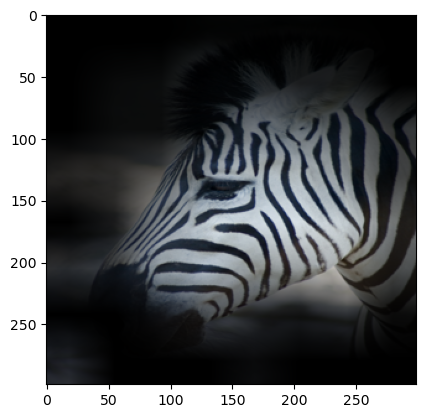

In [9]:
plt.imshow(masked_imgs['conv4'][0])

# Step 2
- TCAV method로 masked image들의 conceptual sensitivity 구하기

In [10]:
layer_names = ['mixed8', 'mixed9', 'mixed10']
target_class_names = ['zebra']
concept_names = ['striped']
random_concept_names = ['random1', 'random2', 'random3']
concept_pairs = []

for c in concept_names:
    for rc in random_concept_names:
        concept_pairs.append([c, rc])

layer_outputs = [model.get_layer(name).output for name in layer_names]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [11]:
input_imgs = {}
concepts = {}
randoms = {}

target_path = glob.glob('test_data/zebra/*')
concept_path = glob.glob('test_data/striped/*')
random_paths = [
    glob.glob('test_data/random1/*'),
    glob.glob('test_data/random2/*'),
    glob.glob('test_data/random3/*')
]

target_imgs = load_and_preprocess_images(target_path, target_size=(299,299))
concept_imgs = load_and_preprocess_images(concept_path, target_size=(299,299))
random_imgs = [load_and_preprocess_images(paths, target_size=(299,299)) for paths in random_paths]

concepts['zebra'] = target_imgs 
concepts['striped'] = concept_imgs
input_imgs['concepts'] = concepts

for i, random_img in enumerate(random_imgs):
    randoms[f'random{i+1}'] = random_img

input_imgs['randoms'] = randoms

In [12]:
input_imgs['concepts']['zebra'].shape

(37, 299, 299, 3)

In [13]:
for k in input_imgs.keys():
    for k2 in input_imgs[k].keys():
        activations = activation_model.predict(input_imgs[k][k2])
        for i, act in enumerate(activations):
            np.save(f'./acts_inceptionv3/{k2}_{layer_names[i]}', act, allow_pickle=False)

2/2 [==============================] - 1s 230ms/step


In [14]:
# 딕셔너리 초기화
acts = {}

# 파일 불러와서 딕셔너리에 저장
for file_path in glob.glob('./acts_inceptionv3/*'):
    # 파일 이름에서 concept와 layer 추출
    file_name = os.path.basename(file_path)
    parts = file_name.split('_')
    concept = parts[0]
    layer = parts[1].replace('.npy', '')
    
    # 데이터 불러오기
    data = np.load(file_path)
    
    # 딕셔너리에 저장
    if concept not in acts:
        acts[concept] = {}
    acts[concept][layer] = data

# 결과 확인
for concept, layers in acts.items():
    for layer, data in layers.items():
        print(f"Concept: {concept}, Layer: {layer}, Data shape: {data.shape}")

Concept: random1, Layer: mixed9, Data shape: (44, 8, 8, 2048)
Concept: random1, Layer: mixed8, Data shape: (44, 8, 8, 1280)
Concept: random1, Layer: mixed10, Data shape: (44, 8, 8, 2048)
Concept: random3, Layer: mixed10, Data shape: (40, 8, 8, 2048)
Concept: random3, Layer: mixed8, Data shape: (40, 8, 8, 1280)
Concept: random3, Layer: mixed9, Data shape: (40, 8, 8, 2048)
Concept: random2, Layer: mixed10, Data shape: (42, 8, 8, 2048)
Concept: random2, Layer: mixed8, Data shape: (42, 8, 8, 1280)
Concept: random2, Layer: mixed9, Data shape: (42, 8, 8, 2048)
Concept: striped, Layer: mixed8, Data shape: (50, 8, 8, 1280)
Concept: striped, Layer: mixed9, Data shape: (50, 8, 8, 2048)
Concept: striped, Layer: mixed10, Data shape: (50, 8, 8, 2048)
Concept: zebra, Layer: mixed8, Data shape: (37, 8, 8, 1280)
Concept: zebra, Layer: mixed9, Data shape: (37, 8, 8, 2048)
Concept: zebra, Layer: mixed10, Data shape: (37, 8, 8, 2048)


In [15]:
cavs = {}

for layer_name in layer_names:
    cavs[layer_name] = {}
    for concept_pair in concept_pairs:
        x, labels, labels2text = create_cav_training_set(concept_pair, layer_name, acts)
        lm = linear_model.SGDClassifier(alpha=0.1, max_iter=1000, tol=1e-3)
        acc = train_lm(lm, x, labels, labels2text)
        cav = [-1*lm.coef_[0], lm.coef_[0]]
        cavs[layer_name][concept_pair[0]]= cav

INFO:tensorflow:acc per class {'striped': 1.0, 'random1': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 0.9230769230769231, 'random2': 1.0, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 1.0, 'random3': 0.9166666666666666, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 1.0, 'random1': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random2': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 0.9166666666666666, 'random3': 1.0, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 0.8461538461538461, 'random1': 1.0, 'overall': 0.92}
INFO:tensorflow:acc per class {'striped': 0.9166666666666666, 'random2': 1.0, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 0.9230769230769231, 'random3': 0.9166666666666666, 'overall': 0.92}


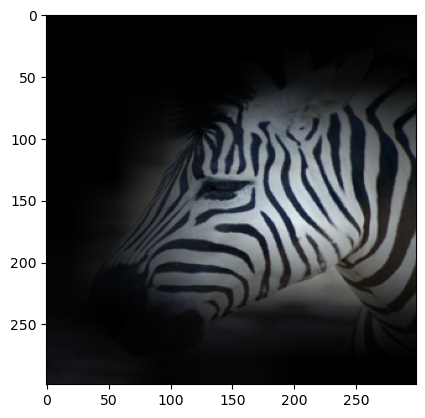

In [16]:
plt.imshow(masked_imgs['conv4'][20])

In [17]:
masked_imgs['conv4'][0].shape

(299, 299, 3)

In [18]:
layer_gradients = {}
cs = {}
batch_size = 32

if os.path.isfile('./cs_data/conv4_cs.pkl'):
    with open('./cs_data/conv4_cs.pkl', 'rb') as pickle_file:
        loaded_cs = pickle.load(pickle_file)
else:
    num_batches = masked_imgs['conv4'].shape[0] // batch_size + (1 if masked_imgs['conv4'].shape[0] % batch_size != 0 else 0)
    
    for layer_name in layer_names:
        img = tf.convert_to_tensor(input_imgs['concepts']['zebra'])
    
        cs[layer_name] = []
        for i in range(num_batches):
            with tf.GradientTape() as tape:
                tape.watch(img)
                logits_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    
                layer_act, logits = logits_model(masked_imgs['conv4'][i*batch_size:(i+1)*batch_size])
                selected_logit = logits[:, 340]
    
            gradient = tape.gradient(selected_logit, layer_act)
    
            if gradient is None:
                raise ValueError("Gradient computation returned None. Ensure the input tensor is correctly tracked.")
            layer_gradients[layer_name] = gradient
    
            for grad in layer_gradients[layer_name]:
                cs[layer_name].append(np.dot(np.reshape(grad,-1), cavs[layer_name]['striped'][0]))
    
    with open('./cs_data/conv4_cs.pkl', 'wb') as pickle_file:
        pickle.dump(cs, pickle_file)

In [17]:
X_train = masked_imgs['conv4'].reshape(883, -1)

In [18]:
X_train.shape

(883, 268203)

In [19]:
np.array(loaded_cs['mixed8']).shape

(883,)

In [20]:
masked_imgs['conv4'].shape

(883, 299, 299, 3)

In [21]:
%%time
local_model = train_local_surrogate_model(masked_imgs['conv4'], model, 340)

28/28 [==============================] - 25s 853ms/step
CPU times: user 6min 22s, sys: 25.8 s, total: 6min 48s
Wall time: 58.4 s


In [22]:
importance = evaluate_feature_importance(local_model, masked_imgs['conv4'])

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
%%time
sensitivity_model = local_weighted_regression(X_train, np.array(loaded_cs['mixed8']), tau=0.1, batch_size=8)

CS까지 구함

In [ ]:
masked_imgs['conv4'].shape

InceptionV3
- (9) activation_2 - 64
- (16) activation_4 - 192
- (86) mixed2 - 288
- (228) mixed7 - 768
- (310) mixed10 - 2048

레이어 선택 기준: 피쳐의 크기가 감소하기 전의 레이어 선택
- InceptionV3 모델의 경우는 피쳐맵 하나에서 여러개의 분기로 나눠져 따로 다운 샘플링 되기 때문에 크기가 감소하기 전 concat 레이어를 선택함